# Initialization

In [86]:
import pandas as pd
import numpy as np
import scipy.integrate
import scipy.signal
from rocketpy import Function
import CoolProp.CoolProp as CoolProp
from CoolProp.CoolProp import PropsSI
import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.4.0


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [10.0, 6.0]
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 120

# Font
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)

# Style
# plt.style.use(['science', 'grid'])

In [8]:
%matplotlib notebook

In [4]:
np.set_printoptions(precision=2)

# Defining Reaction Mechanism

## Mechanism II - Marinov + Mevel

In [5]:
marinov_species = ct.Species.listFromFile('marinov_ethanol_mechanism.cti')
marinov_reactions = ct.Reaction.listFromFile('marinov_ethanol_mechanism.cti')

mevel_species = ct.Species.listFromFile('mevel_ethanol_mechanism.cti')
mevel_reactions = ct.Reaction.listFromFile('mevel_ethanol_mechanism.cti')

new_species = []
new_reactions = []

# Filter species
for specie in mevel_species:
    # Include all nitrogen compounds except for N2
    if 'N' in specie.composition and specie.composition != {'N':2}: new_species.append(specie)

new_species_names = {specie.name for specie in new_species}
# print('N based species: {0}'.format(', '.join(name for name in new_species_names)))

marinov_mevel_species = marinov_species + new_species
marinov_mevel_species_names = {specie.name.upper() for specie in marinov_mevel_species}

# Filter reactions, keeping only those that only involve the selected species
# print('\nReactions:')
for R in mevel_reactions:
    if any(reactant in new_species_names for reactant in R.reactants) or any(product in new_species_names for product in R.products):
        # for reactant in R.reactants:
            # if reactant not in marinov_mevel_species_names:
                # print('Missing reactant:', reactant, 'when analyzing reaction', R.equation)
        # for product in R.products:
            # if product not in marinov_mevel_species_names:
                # print('Missing product:', product, 'when analyzing reaction', R.equation)
        if all(reactant in marinov_mevel_species_names for reactant in R.reactants):
            if all(product in marinov_mevel_species_names for product in R.products):
                new_reactions.append(R)
                # print('Accepted reaction:', R.equation)
# print('\n')

marinov_mevel_species = marinov_species + new_species
marinov_mevel_reactions = marinov_reactions + new_reactions

marinov_mevel_gas = ct.Solution(
    thermo='IdealGas',
    kinetics='GasKinetics',
    species=marinov_mevel_species,
    reactions=marinov_mevel_reactions
)

marinov_mevel_gas = ct.Solution('sandiego2016_plus_N_CK.cti')
print('Number of species:', marinov_mevel_gas.n_species)
print('Number of reactions:', marinov_mevel_gas.n_reactions)



**** WARNING ****
For species C2H4OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.4211
	Value computed using high-temperature polynomial: 18.7409


**** WARNING ****
For species C2H4OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  14.778
	Value computed using high-temperature polynomial: 14.7264


**** WARNING ****
For species OC2H3OOH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  18.7616
	Value computed using high-temperature polynomial: 19.0815


**** WARNING ****
For species OC2H3OOH, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -18.695
	Value computed using high-temperature polynomial: -18.741


**** WARNING ****
For species CH2CH2OH, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  15.1078
	Value computed using high-tempe

# Droplet Fed Variable Area Plug Flow Reactor Model

In [459]:
class NoelleReactor(object):
    def __init__(self, gas, area, liquid, N_dot):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.Tmin = 1000
        self.A = area
        self.dA_dx = Function(lambda x: area.differentiate(x))
        self.N_dot = N_dot
        
        # Liquid information - always at boiling temperature
        self.droplets_exist = True
        self.liquid = liquid
        self.liquid.update(CoolProp.PQ_INPUTS, self.gas.P, 0)
        ## Density
        self.rho_l = self.liquid.rhomass()
        ## Boiling temperature
        self.T_l = self.liquid.T()
        ## Heat of vaporization
        self.liquid.update(CoolProp.PQ_INPUTS, self.gas.P, 1)
        h_v = self.liquid.hmass()
        self.liquid.update(CoolProp.PQ_INPUTS, self.gas.P, 0)
        h_l = self.liquid.hmass()
        self.h_fg = h_v - h_l
        
        self.last_x = -100
        self.multiphase = True
    
    def __call__(self, x, u):
        if u[0] > 0 and self.multiphase:
            return self.state_derivate_with_droplets(x, u)
        else:
            if self.multiphase:
                print('Changing derivative')
                self.multiphase = False
            return self.state_derivate_without_droplets(x, u)

    def state_derivate_with_droplets(self, x, u):
        """ ODE function u'= f(x, u).
        
        Parameters
        ----------
        x : float
            Axial position in meters.
        u : np.array
            State variable. Variables are:
            u[0] = D^2 (droplet diameter (SMD) squared)
            u[1] = ml (liquid phase flow rate)
            u[2] = mg (gas phase flow rate)
            u[3] = v_d (droplet velocity)
            u[4] = rho_g (gas phase density)
            u[5] = T (gas phase temperature)
            u[6:6+N] = Y_i (mass fraction of the i-th species, out of N species)       
        """
        # Get variables from state variable
        D2, ml, mg, v_d, rho_g, T = u[:6]
        Y = u[6:]
        D = (abs(D2)**0.5)*1e-6
        A = self.A(x)
        dA_dx = self.dA_dx(x)
        v_g = mg/(rho_g*A)
        rho_l = self.rho_l
        
        T = max(self.Tmin, T)
        if T < 0:
            print(x, T)
        
        # Update gas state
        self.gas.set_unnormalized_mass_fractions(Y)
        self.gas.TP = T, rho_g*ct.gas_constant*T/(self.gas.mean_molecular_weight)
        
        # Get cp, MW, omega, etc
        R_u = ct.gas_constant
        cp = self.gas.cp
        omega_i = self.gas.net_production_rates
        MW_i = self.gas.molecular_weights
        MW_mix = self.gas.mean_molecular_weight
        h_i = self.gas.partial_molar_enthalpies # *self.gas.molecular_weights
        mu_g = self.gas.viscosity # PropsSI('viscosity','T', T, 'P', P, 'Air') # Pa*s
        # rho_g = self.gas.density
        
        # Compute dD^2/dx
        T_bar = 0.5*T + 0.5*self.T_l
        try:
            # Update states
            self.gas.TP = T_bar, self.gas.P
            self.liquid.update(CoolProp.PT_INPUTS, self.gas.P, T)
            # Calculate K
            k_v   = self.liquid.conductivity()
            k_inf = self.gas.thermal_conductivity # PropsSI('conductivity','T', T, 'P', P, 'Air')
            kg    = 0.4*k_v + 0.6*k_inf
            c_pv  = self.liquid.cpmass()
            K     = 8*kg/(rho_l*c_pv) * np.log(1 + c_pv*(T - self.T_l)/self.h_fg)
            # Roll back states
            self.gas.TP = T, self.gas.P
            self.liquid.update(CoolProp.PQ_INPUTS, self.gas.P, 0)
        except ValueError as E:
            # print(E)
            # print('ERROR! State Variable:', u)
            # print('Using K = 7.25e-7 to continue.')
            K = 7.25e-07
        dD2_dx = -K/v_d * 1e12

        # Compute dml/dx and dmg/dx
        dml_dx = np.pi/4 * self.N_dot * rho_l * D * dD2_dx * 1e-12
        dmg_dx = -dml_dx

        # Compute drho_g/dx
        # TODO: verify if droplets affect this equation
        drho_g_dx = (
            (1 - R_u/(cp*MW_mix)) * (rho_g**2) * (v_g**2) * (dA_dx/A) +
            ((rho_g*R_u)/(v_g*cp*MW_mix)) * sum(omega_i*(h_i - cp*T*MW_mix))
        )/(
            P*(1+ (v_g**2)/(cp*T) - rho_g*v_g**2)
        )

        # Compute dT/dx
        # TODO: add droplet heat of vaporization
        dT_dx = (
            ((v_g**2)/rho_g*cp) * drho_g_dx +
            ((v_g**2)/cp) * (dA_dx/A) -
            (1/(v_g*rho_g*cp))*sum(h_i*omega_i)
        )

        # Compute dY_dx
        dY_dx = omega_i * MW_i / (rho_g*v_g)
        # Add droplet vaporization term to ethanol mass fraction
        dY_dx[37] += dmg_dx/mg

        # Compute dv_d/dx
        v_rel = v_d - v_g
        Re = rho_g*abs(v_d - v_g)*D/mu_g
        Cd = 24/Re + 6/(1+np.sqrt(Re)) + 0.4
        dv_d_dx = -(3*Cd*rho_g*v_rel**2)/(4*rho_l*v_d*D)*v_rel/abs(v_rel)
        
        if np.isnan(sum(np.hstack(([dD2_dx, dml_dx, dmg_dx, dv_d_dx, drho_g_dx, dT_dx], dY_dx)))):
            print(u[:6])
            print([dD2_dx, dml_dx, dmg_dx, dv_d_dx, drho_g_dx, dT_dx])
            print(self.N_dot)
            print(rho_l)
            print(D)
            print(dD2_dx)
        
#         if x - self.last_x > 0.001: print(x)
#         self.last_x = x
        
        return np.hstack(([dD2_dx, dml_dx, dmg_dx, dv_d_dx, drho_g_dx, dT_dx], dY_dx))
        
    def state_derivate_without_droplets(self, x, u):
        """ ODE function u'= f(x, u).
        
        Parameters
        ----------
        x : float
            Axial position in meters.
        u : np.array
            State variable. Variables are:
            u[0] = D^2 (droplet diameter (SMD) squared)
            u[1] = ml (liquid phase flow rate)
            u[2] = mg (gas phase flow rate)
            u[3] = v_d (droplet velocity)
            u[4] = rho_g (gas phase density)
            u[5] = T (gas phase temperature)
            u[6:6+N] = Y_i (mass fraction of the i-th species, out of N species)       
        """
        # Get variables from state variable
        self.droplets_exist = False
        D2, ml, mg, v_d, rho_g, T = u[:6]
        Y = u[6:]
        A = self.A(x)
        dA_dx = self.dA_dx(x)
        v_g = mg/(rho_g*A)
        rho_l = self.rho_l
        
        T = max(self.Tmin, T)
        if T < 0:
            print(x, T)
        
        # Update gas state
        self.gas.set_unnormalized_mass_fractions(Y)
        self.gas.TP = T, rho_g*ct.gas_constant*T/(self.gas.mean_molecular_weight)
        
        # Get cp, MW, omega, etc
        R_u = ct.gas_constant
        cp = self.gas.cp
        omega_i = self.gas.net_production_rates
        MW_i = self.gas.molecular_weights
        MW_mix = self.gas.mean_molecular_weight
        h_i = self.gas.partial_molar_enthalpies
        mu_g = self.gas.viscosity # PropsSI('viscosity','T', T, 'P', P, 'Air') # Pa*s
        
        dD2_dx = 0
        dml_dx = 0
        dmg_dx = 0
        dv_d_dx = 0

        # Compute drho_g/dx
        drho_g_dx = (
            (1 - R_u/(cp*MW_mix)) * (rho_g**2) * (v_g**2) * (dA_dx/A) +
            ((rho_g*R_u)/(v_g*cp*MW_mix)) * sum(omega_i*(h_i - cp*T*MW_mix))
        )/(
            P*(1+ (v_g**2)/(cp*T) - rho_g*v_g**2)
        )

        # Compute dT/dx
        dT_dx = (
            ((v_g**2)/rho_g*cp) * drho_g_dx +
            ((v_g**2)/cp) * (dA_dx/A) -
            (1/(v_g*rho_g*cp))*sum(h_i*omega_i)
        )

        # Compute dY_dx
        dY_dx = omega_i * MW_i / (rho_g*v_g)        
        
        return np.hstack(([dD2_dx, dml_dx, dmg_dx, dv_d_dx, drho_g_dx, dT_dx], dY_dx))      

# Setting Up Gas, Reactor and Initial Conditions

In [460]:
# State
T_0 = 1300 # K
P = 15e5 # Pa

# Gas
gas = marinov_mevel_gas
gas.TPY = T_0, P, 'N2O: 1.0'
# gas.TP = T_0, P
# gas.set_equivalence_ratio(1.0, fuel='C2H5OH', oxidizer='N2O')

# Liquid
liquid = CoolProp.AbstractState("HEOS", "Ethanol") # &Water")
# liquid.set_mass_fractions([0.92, 0.08])
liquid.update(CoolProp.PQ_INPUTS, gas.P, 0)
liquid_density = liquid.rhomass()

# Intial conditions
D_0 = 21.4*1e-6 # micro m
D2_0 = (D_0*1e6)**2
ml_0 = 0.209 # kg/s
mg_0 = 1.103 # kg/s
rho_g_0 = gas.density # kg/m3
v_d_0 = 75.0 # m/s

# Geometry
radius = Function('nozzle_geometry.csv', interpolation='linear')
radius.source[:, 1] = scipy.signal.savgol_filter(radius.source[:, 1], 21, 3)
radius.source = radius.source[::3, :]
radius.setInterpolation('spline')
# radius = Function(0.053)
area = np.pi*radius**2

# Droplet flow rate
N_dot = 6*ml_0/(liquid_density*np.pi*D_0**3)

# Reactor
reactor = NoelleReactor(gas, area, liquid, N_dot)

# reactor.A()
# reactor.dA_dx.plot(-0.275, 0.6)

# Numerical Integration

In [461]:
x_init = -0.275
x_max = 0.060

initial_state = np.hstack(([D2_0, ml_0, mg_0, v_d_0, rho_g_0, T_0], gas.Y))

sol_with_droplets = scipy.integrate.solve_ivp(
    fun=reactor,
    t_span=(x_init, x_max),
    y0=initial_state,
    method='BDF',
    t_eval=None,
    dense_output=False,
    events=lambda x, u: u[0],
    max_step=0.001
)

Changing derivative


In [462]:
plt.figure(figsize=(10,6))

x_mesh = 1000*sol_with_droplets.t
diameter_ratio = np.sqrt(sol_with_droplets.y[0])/(D_0*1e6)
droplet_velocity_ratio = sol_with_droplets.y[3]/sol_with_droplets.y[3][0]
temperature_ratio = sol_with_droplets.y[5]/3000
gas_density = sol_with_droplets.y[4]/sol_with_droplets.y[4, 0]
ethanol_mass_fraction = sol_with_droplets.y[37+6]
pressure = sol_with_droplets.y[4]*ct.gas_constant*sol_with_droplets.y[5]/(gas.mean_molecular_weight)/P

plt.plot(x_mesh, diameter_ratio, label='Droplet diameter $D/D_0$', linewidth=2)
plt.plot(x_mesh, droplet_velocity_ratio, label='Droplet velocity ratio', linewidth=2)
plt.plot(x_mesh, temperature_ratio, label='Temperature ratio $T/T_{ad}$', linewidth=2)
plt.plot(x_mesh, area(x_mesh/1000)/max(area(x_mesh/1000)), label='Area ratio $A/A_{*}$', linewidth=2)
plt.plot(x_mesh, gas_density, label=r'Gas Density $\rho/\rho_0$', linewidth=2)
plt.plot(x_mesh, ethanol_mass_fraction, label=r'Ethanol mass fraction', linewidth=2)
# plt.plot(x_mesh, pressure, label=r'Pressure', linewidth=2)

plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('Non-dimensional parameters')
plt.legend()
plt.savefig('1d_combustion_model.pdf')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [372]:
sol_with_droplets

  message: 'A termination event occurred.'
     nfev: 443
     njev: 40
      nlu: 72
      sol: None
   status: 1
  success: True
        t: array([-0.28, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27, -0.27,
       -0.27, -0.2

In [271]:
reactor.gas.set_unnormalized_mass_fractions(sol_with_droplets.y[6:, -1])
reactor.gas()


  gas:

       temperature            1000  K
          pressure     1.49995e+06  Pa
           density         6.80294  kg/m^3
  mean mol. weight         37.7097  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      2.0352e+06        7.675e+07     J
   internal energy      1.8147e+06        6.843e+07     J
           entropy    -nan             -nan             J/K
    Gibbs function    -nan             -nan             J
 heat capacity c_p            1787        6.739e+04     J/K
 heat capacity c_v          1566.5        5.907e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2    0.000202273      0.000150263         -30.6616
                 H    2.86502e-08      7.65789e-10          -3.5223
                O2    1.66135e-09      1.40975e-09         -44.0865
                OH    7.2798

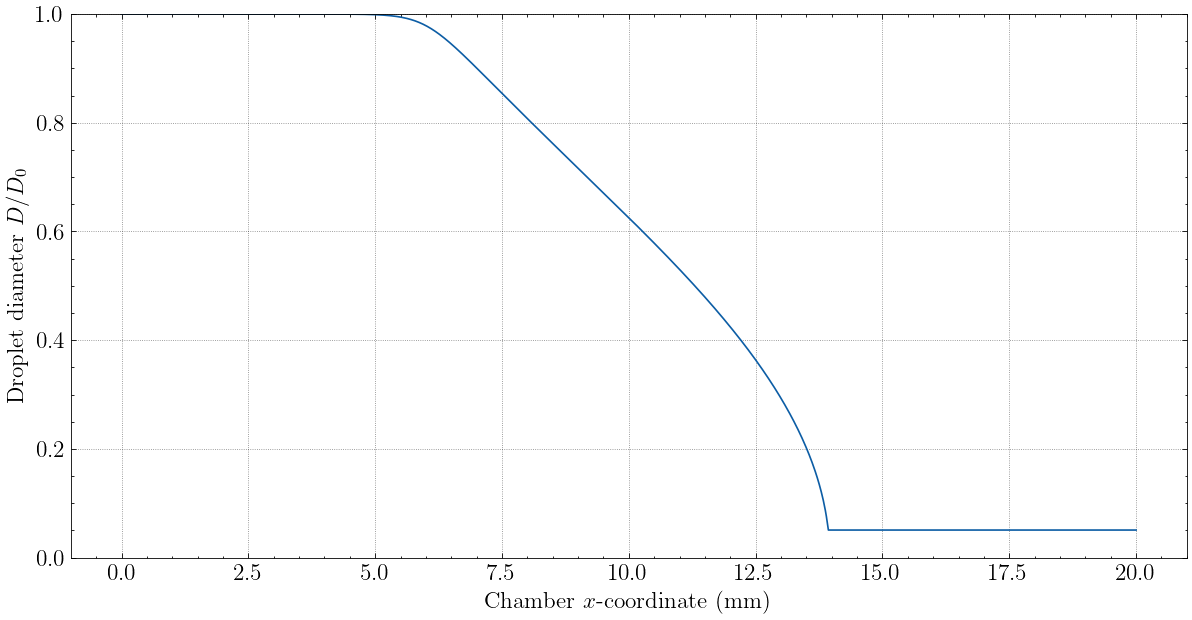

In [123]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, np.sqrt(sol[:, 0])/(D_0*1e6))
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('Droplet diameter $D/D_0$')
plt.ylim(0, 1)
plt.show()

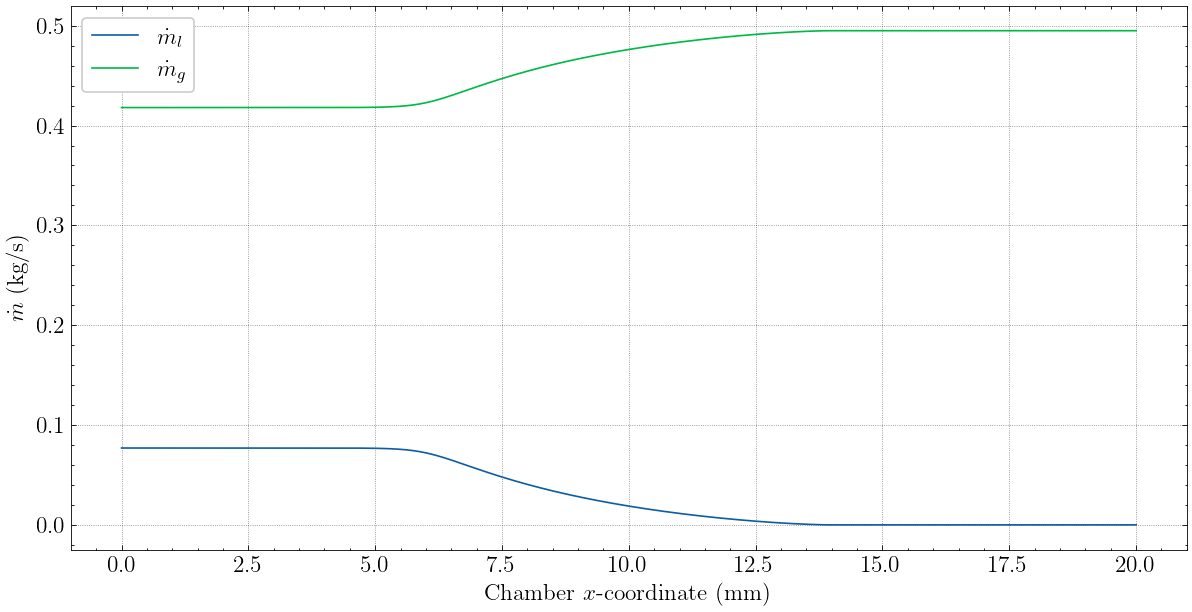

In [108]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 1], label=r'$\dot{m}_{l}$')
plt.plot(1000*x_mesh, sol[:, 2], label=r'$\dot{m}_{g}$')
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('$\dot{m}$ (kg/s)')
plt.legend()
plt.show()

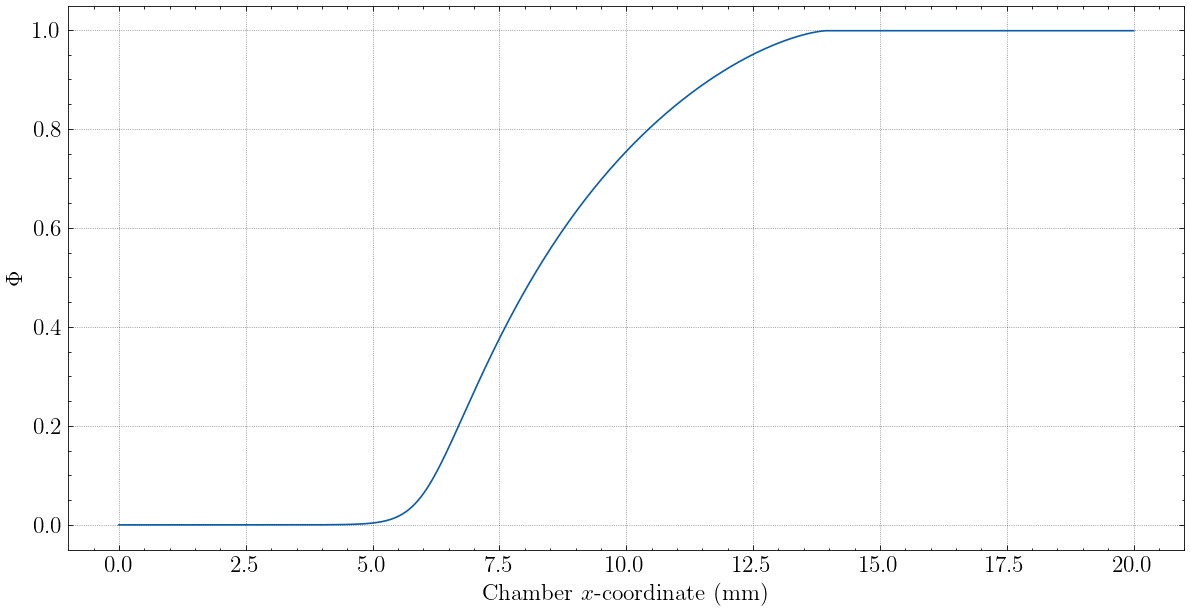

In [109]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 3])
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('$\Phi$')
plt.show()

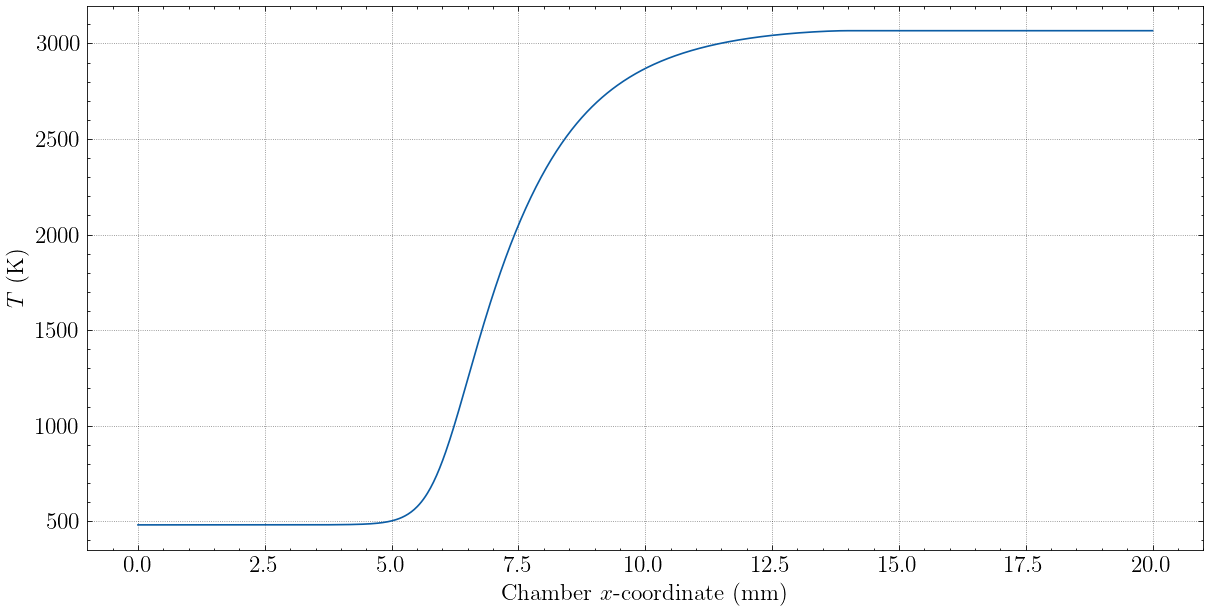

In [110]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 4])
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('$T$ (K)')
plt.show()

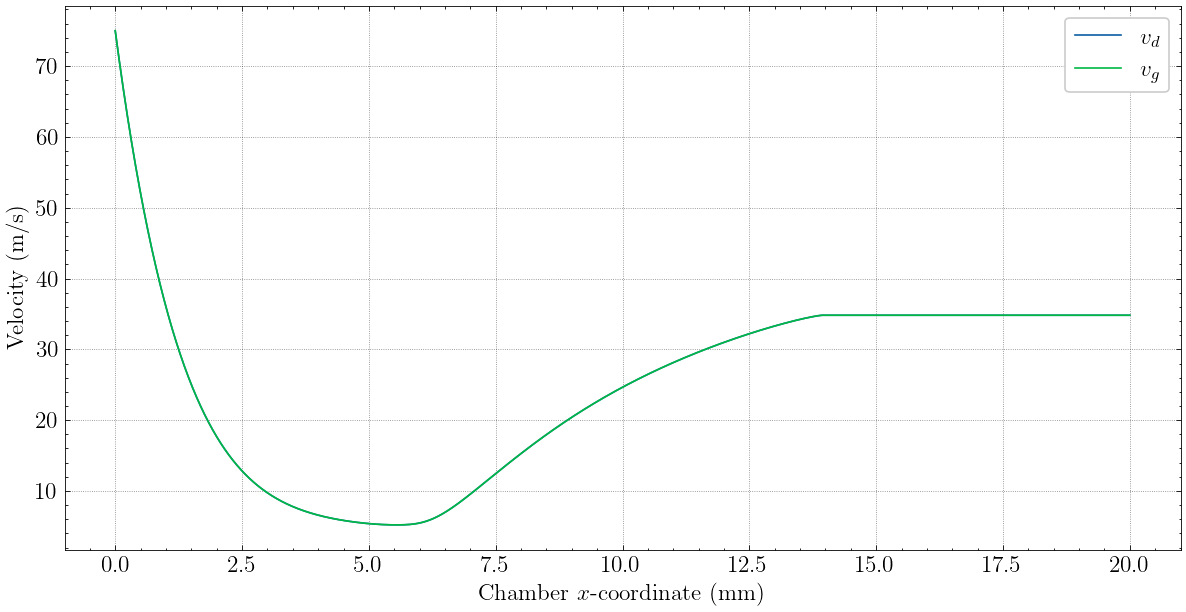

In [111]:
plt.figure(figsize=(12,6))
plt.plot(1000*x_mesh, sol[:, 5], label='$v_d$')
plt.plot(1000*x_mesh, sol[:, 5], label='$v_g$')
plt.xlabel('Chamber $x$-coordinate (mm)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()